In [ ]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, classification_report


Importing data and systematically organisation into folders 

In [ ]:
input_dir = "./archive (6)"

for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))



./archive (6)\anger\11647173796_033ff06112_n_face.png
./archive (6)\anger\1379351899_7cfa2b0dc4_b_face.png
./archive (6)\anger\14187801814_ea89208940_b_face.png
./archive (6)\anger\22600236939_54d0e01905_n_face.png
./archive (6)\anger\22721287949_65572bea8b_n_face.png
./archive (6)\anger\22913025801_2822113219_n_face.png
./archive (6)\anger\24063912157_38a4f8d093_b_face.png
./archive (6)\anger\2971847861_5c6fe61308_b_face.png
./archive (6)\anger\2Q__ (1)_face.png
./archive (6)\anger\2Q__ (2)_face.png
./archive (6)\anger\2Q__ (3)_face.png
./archive (6)\anger\2Q__ (5)_face.png
./archive (6)\anger\2Q___face.png
./archive (6)\anger\30313832521_d63b8e0dcb_b_face.png
./archive (6)\anger\31049558135_aba6aa9495_n_face.png
./archive (6)\anger\31779682004_a9efa7d01e_n_face.png
./archive (6)\anger\32389337586_9f0fb42512_n_face.png
./archive (6)\anger\33824758533_a82fc5b885_b_face.png
./archive (6)\anger\372662640_e8dc799d8b_b_face.png
./archive (6)\anger\4604139529_c23a5a462a_n_face.png
./archive

Demarcating disjoint classes and displaying class distribution

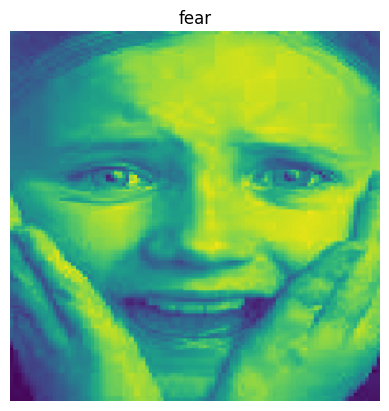

In [ ]:
emotion_dirs = {
    'fear': './archive (6)/fear/',
    'happiness': './archive (6)/happiness/',
    'neutrality': './archive (6)/neutrality/',
    'sadness': './archive (6)/sadness/',
    'surprise': './archive (6)/surprise/'
}

# List to hold image paths and their corresponding emotion labels
image_data = []

for emotion, dir_path in emotion_dirs.items():
    for file_name in os.listdir(dir_path):
        if file_name.endswith('.png'):  
            image_path = os.path.join(dir_path, file_name)
            image_data.append([image_path, emotion])

# Create a DataFrame with two columns: 'image_path' and 'emotion'
df = pd.DataFrame(image_data, columns=['image_path', 'emotion'])

def load_image(image_path):
    return Image.open(image_path)

# Example: Loading the first image and displaying it inline
example_image = load_image(df['image_path'][0])

plt.imshow(example_image)
plt.axis('off')  
plt.title(df['emotion'][0]) 
plt.show()  


In [3]:
df.head()

,image_path,emotion
0,./archive (6)/fear/2Q__ (2)_face.png,fear
1,./archive (6)/fear/2Q__ (3)_face.png,fear
2,./archive (6)/fear/2Q__ (4)_face.png,fear
3,./archive (6)/fear/2Q__ (5)_face.png,fear
4,./archive (6)/fear/2Q__ (6)_face.png,fear


In [ ]:
class_counts = Counter(df['emotion'])

# Display class frequencies
print("Class Frequencies:", class_counts)
class_df = pd.DataFrame(class_counts.items(), columns=['class', 'count'])

Class Frequencies: Counter({'happiness': 1406, 'surprise': 775, 'sadness': 746, 'fear': 570, 'neutrality': 524})


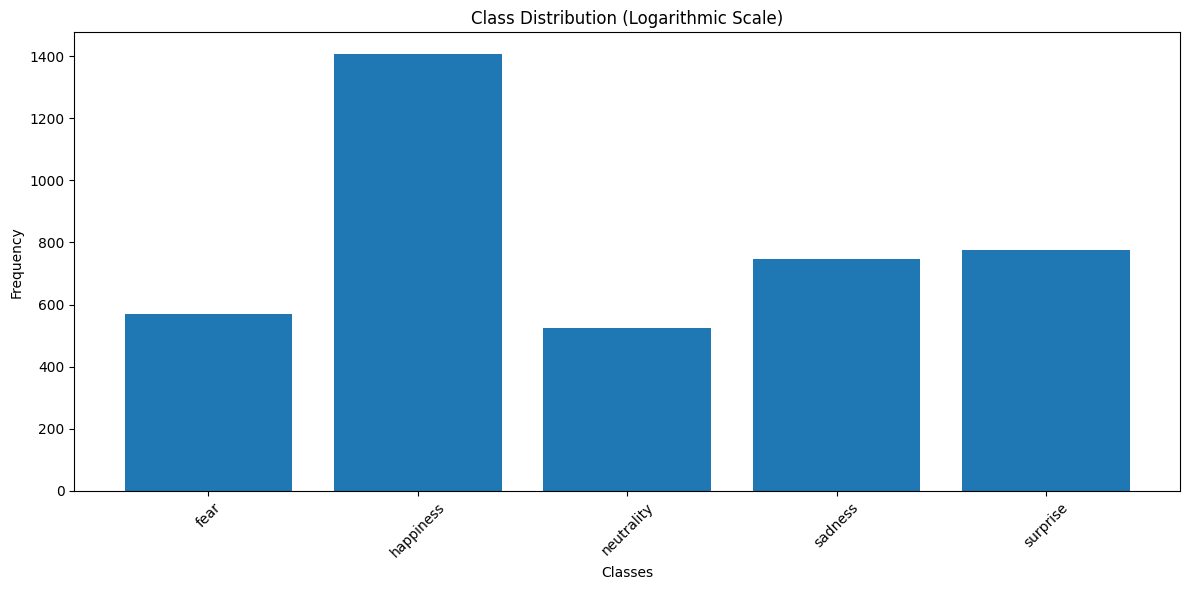

In [5]:
# Plotting the class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_df['class'], class_df['count'])
plt.xticks(rotation=45)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Distribution (Logarithmic Scale)')


plt.tight_layout()
plt.show()


In [ ]:
label_encoder = LabelEncoder()

# Perform label encoding and create a new column 'emotion_encoded'
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])
df.head()

,image_path,emotion,emotion_encoded
0,./archive (6)/fear/2Q__ (2)_face.png,fear,0
1,./archive (6)/fear/2Q__ (3)_face.png,fear,0
2,./archive (6)/fear/2Q__ (4)_face.png,fear,0
3,./archive (6)/fear/2Q__ (5)_face.png,fear,0
4,./archive (6)/fear/2Q__ (6)_face.png,fear,0


doing data augmentation by adding images with slight modification such as flipping, rotating, etc. to create more copies to counter class imbalance 

In [ ]:
# Define augmentations using torchvision.transforms
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))
])

# Function to load an image, apply augmentation, and save it
def augment_image(image_path, count):
    img = Image.open(image_path)
    augmented_img = augmentations(img)
    
    # Construct the new image name with '_aug' in the name
    base_name, ext = os.path.splitext(image_path)
    new_img_name = f"{base_name}_aug_{count}{ext}"
    
    # Save the augmented image
    augmented_img.save(new_img_name)
    
    return new_img_name, augmented_img

target_count = 1000

augmented_data = []
sample_augmented_images = []  # To store some augmented images for display

# Loop through each class in class_df and augment images
for index, row in class_df.iterrows():
    emotion = row['class']
    count = row['count']
    
    if count < target_count:
        class_images = df[df['emotion'] == emotion]['image_path'].tolist()
        images_needed = target_count - count
        
        # Randomly augment existing images to reach the target count
        for i in range(images_needed):
            img_path = random.choice(class_images)
            new_img_name, augmented_img = augment_image(img_path, i)
            
            augmented_data.append([new_img_name, emotion, df[df['image_path'] == img_path]['emotion_encoded'].values[0]])

            if len(sample_augmented_images) < 5:  
                sample_augmented_images.append(augmented_img)

# Create new DataFrame with augmented image paths
augmented_df = pd.DataFrame(augmented_data, columns=['image_path', 'emotion', 'emotion_encoded'])

# Append augmented data to the original DataFrame
balanced_df = pd.concat([df, augmented_df], ignore_index=True)

print("Class-wise augmentation completed and images saved.")



Class-wise augmentation completed and images saved.


In [8]:

class_counts2 = Counter(balanced_df['emotion'])

# Display class frequencies
print("Class Frequencies:", class_counts2)
class_df = pd.DataFrame(class_counts2.items(), columns=['class', 'count'])

Class Frequencies: Counter({'happiness': 1406, 'fear': 1000, 'neutrality': 1000, 'sadness': 1000, 'surprise': 1000})


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image_path']
        image = Image.open(image_path).convert("RGB")
        label = self.df.iloc[idx]['emotion_encoded']

        if self.transform:
            image = self.transform(image)

        return image, label

# Split dataset into train and test sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['emotion_encoded'], random_state=42)

# Create datasets
train_dataset = EmotionDataset(train_df, transform=train_transforms)
test_dataset = EmotionDataset(test_df, transform=test_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 5)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = EmotionCNN()


In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

print("Training complete.")


Epoch [1/10], Loss: 1.8998
Epoch [2/10], Loss: 1.4520
Epoch [3/10], Loss: 1.1118
Epoch [4/10], Loss: 0.6869
Epoch [5/10], Loss: 0.3169
Epoch [6/10], Loss: 0.1233
Epoch [7/10], Loss: 0.0725
Epoch [8/10], Loss: 0.0615
Epoch [9/10], Loss: 0.0569
Epoch [10/10], Loss: 0.0325
Training complete.


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Test Accuracy: 0.51
              precision    recall  f1-score   support

        fear       0.37      0.47      0.41       200
   happiness       0.67      0.75      0.71       282
  neutrality       0.47      0.47      0.47       200
     sadness       0.47      0.28      0.35       200
    surprise       0.51      0.48      0.49       200

    accuracy                           0.51      1082
   macro avg       0.50      0.49      0.49      1082
weighted avg       0.51      0.51      0.50      1082

